#### All imports

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import hog

from scipy.ndimage.measurements import label

import glob
import time

from moviepy.editor import VideoFileClip
from IPython.display import HTML

#### Spatial features

In [2]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:, :, 0], size).ravel()
    color2 = cv2.resize(img[:, :, 1], size).ravel()
    color3 = cv2.resize(img[:, :, 2], size).ravel()
    return np.hstack((color1, color2, color3))

#### Color histogram features

In [3]:
def color_hist(img, nbins=32):
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins, range=(0, 256))
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins, range=(0, 256))
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins, range=(0, 256))
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

#### Hog features

In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [5]:
orient = 9
pix_per_cell = 8
cell_per_block = 2

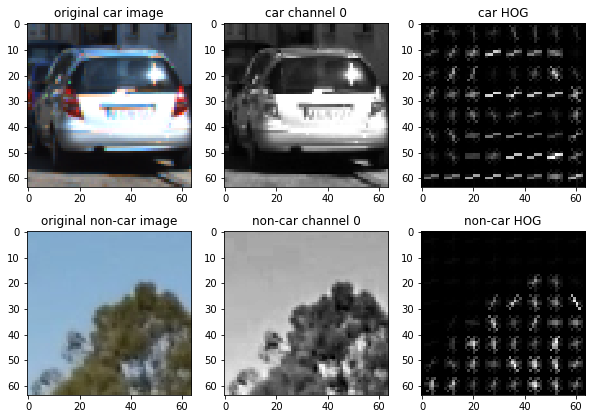

In [6]:
plt.figure(figsize=(10, 7))

car_imfile = 'vehicles/KITTI_extracted/901.png'
img = mpimg.imread(car_imfile)
features, hog_image = get_hog_features(img[:, :, 0], orient, pix_per_cell, cell_per_block, vis=True)
plt.subplot(231)
plt.imshow(img)
plt.title('original car image')
plt.subplot(232)
plt.imshow(img[:, :, 0], cmap='gray')
plt.title('car channel 0')
plt.subplot(233)
plt.imshow(hog_image, cmap='gray')
plt.title('car HOG')

notcar_imfile = 'non-vehicles/Extras/extra89.png'
img = mpimg.imread(notcar_imfile)
features, hog_image = get_hog_features(img[:, :, 0], orient, pix_per_cell, cell_per_block, vis=True)
plt.subplot(234)
plt.imshow(img)
plt.title('original non-car image')
plt.subplot(235)
plt.imshow(img[:, :, 0], cmap='gray')
plt.title('non-car channel 0')
plt.subplot(236)
plt.imshow(hog_image, cmap='gray')
plt.title('non-car HOG')


#### Extracting all features from the list of images

In [7]:
def extract_features(imgs, color_convert='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        feature_image = cv2.cvtColor(image, color_convert)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

#### Loading training images and extracting features

In [8]:
color_convert = cv2.COLOR_RGB2YCrCb

spatial_size = (32, 32)
hist_bins = 32
hog_channel = 'ALL'

ystart = 400
ystop = 680

spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')

In [9]:
car_features = extract_features(cars, color_convert, spatial_size, hist_bins, orient, pix_per_cell, 
                                cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)

notcar_features = extract_features(notcars, color_convert, spatial_size, hist_bins, orient, pix_per_cell, 
                                   cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

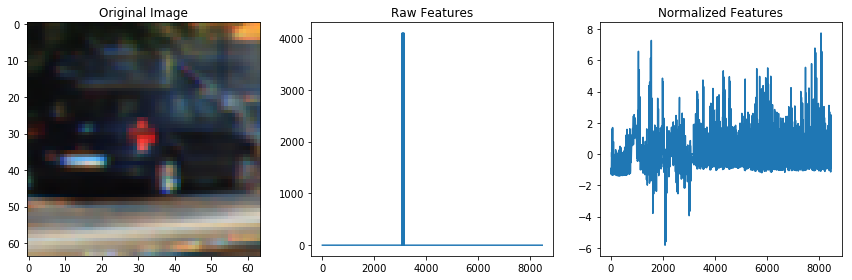

In [10]:
car_ind = np.random.randint(0, len(cars))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

#### Split on training/testing sets and train the classifier

In [11]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.3, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460


In [12]:
# using linear SVC
svc = LinearSVC(C=0.005)
%time svc.fit(X_train, y_train)

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

CPU times: user 7.44 s, sys: 212 ms, total: 7.65 s
Wall time: 7.65 s
Test Accuracy of SVC =  0.9891


#### Move along HOG grid, detect cars and collect bounding boxes

In [13]:
def find_cars(img, color_convert, ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, debug=False):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch_orig = cv2.cvtColor(img_tosearch, color_convert)
    
    boxes = []
    
    for scale in scales:
        if scale != 1:
            imshape = ctrans_tosearch_orig.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch_orig, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:, :, 0]
        ch2 = ctrans_tosearch[:, :, 1]
        ch3 = ctrans_tosearch[:, :, 2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient * cell_per_block ** 2

        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb * cells_per_step
                xpos = xb * cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos * pix_per_cell
                ytop = ypos * pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop: ytop + window, xleft: xleft + window], (64, 64))

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)

                if test_prediction == 1 or debug:
                    xbox_left = np.int(xleft * scale)
                    ytop_draw = np.int(ytop * scale)
                    win_draw = np.int(window * scale)
                    boxes.append(((xbox_left, ytop_draw + ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart)))
    return boxes

#### Find cars and draw all bounding boxes

In [14]:
def process_image(image, scale=(1.5,), video=True, debug=False):

    image = image.astype(np.float32) / 255
    boxes = find_cars(image, color_convert, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, debug)
    out_img = image.copy()
    for box in boxes:
        cv2.rectangle(out_img, (box[0][0], box[0][1]), (box[1][0], box[1][1]), (0, 0, 1), 4) 
    
    # need to multiply back for creating video
    if video:
        out_img *= 255
    return out_img

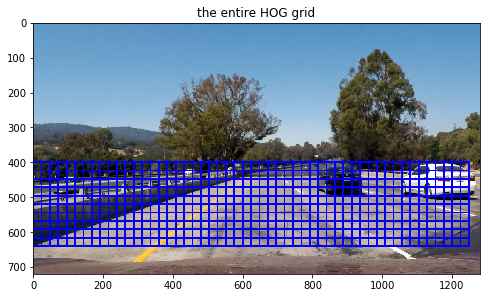

In [15]:
image = mpimg.imread('test_images/test1.jpg')

out_img = process_image(image, video=False, debug=True)
plt.figure(figsize=(8, 5))
plt.imshow(out_img)
plt.title('the entire HOG grid')

#### Draw found boxes for all test images

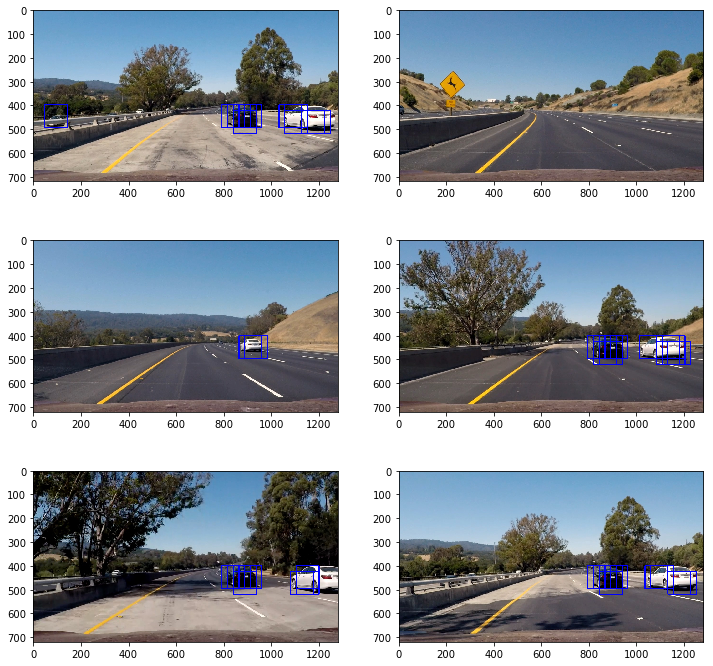

In [16]:
images = glob.glob('test_images/*.jpg')
plt.figure(figsize=(12, 12))
for i in range(len(images)):
    image = mpimg.imread(images[i])
    out_img = process_image(image, video=False)
    plt.subplot(len(images) // 2, 2, i + 1)
    plt.imshow(out_img)

#### Create heatmap for a frame

In [17]:
def create_heatmap(img, bbox_list):
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]: box[1][1], box[0][0]: box[1][0]] += 1
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 1), 6)
    # Return the image
    return img

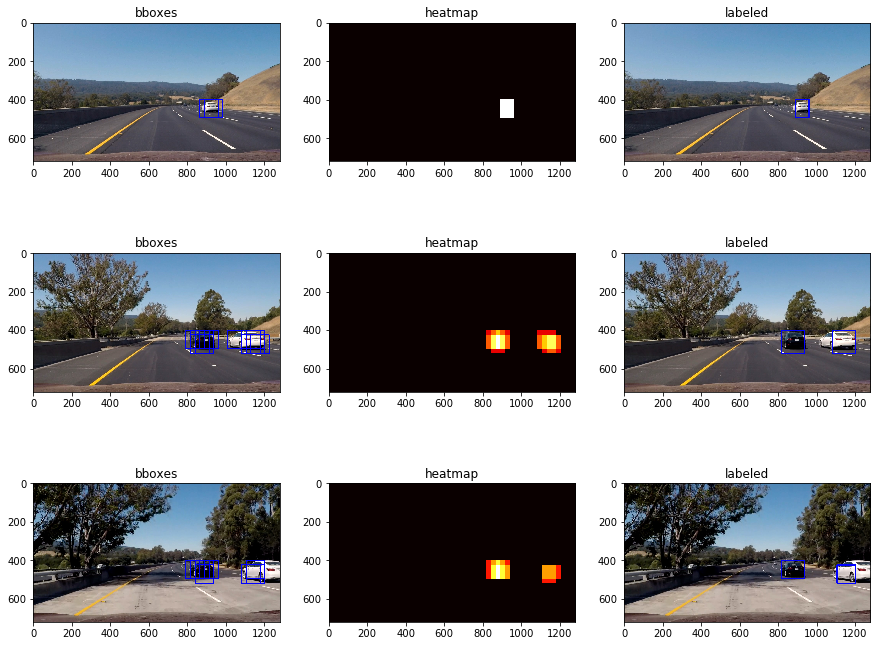

In [18]:
images = glob.glob('test_images/*.jpg')[2:5]
plt.figure(figsize=(15, 12))
for i in range(len(images)):
    image = mpimg.imread(images[i])
    image = image.astype(np.float32) / 255
    boxes = find_cars(image, color_convert,  ystart, ystop, (1.5,),
                      svc, X_scaler,
                      orient, pix_per_cell, cell_per_block,
                      spatial_size, hist_bins)
    out_img = image.copy()
    for box in boxes:
        cv2.rectangle(out_img, (box[0][0], box[0][1]), (box[1][0], box[1][1]), (0, 0, 1), 4) 
    
    heat = create_heatmap(out_img, boxes)
    heat = apply_threshold(heat, 1)
    heatmap = np.clip(heat, 0, 255)
    
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    plt.subplot(len(images), 3, 3 * i + 1)
    plt.imshow(out_img)
    plt.title('bboxes')
    plt.subplot(len(images), 3, 3 * i + 2)
    plt.imshow(heatmap, cmap='hot')
    plt.title('heatmap')
    plt.subplot(len(images), 3, 3 * i + 3)
    plt.title('labeled')
    plt.imshow(draw_img)

#### Final pipeline

In [19]:
def process(image, scale=(1.25, 1.5,), video=True, frames_to_heat=7, threshold=6):
    global heats  # keep heatmaps for several frames
    image = image.astype(np.float32) / 255
    boxes = find_cars(image, color_convert,  ystart, ystop, scale,
                      svc, X_scaler,
                      orient, pix_per_cell, cell_per_block,
                      spatial_size, hist_bins)
    out_img = image.copy()
    
    # Add heat to each box in box list
    heat = create_heatmap(out_img, boxes)
    
    heats.append(heat)
    if len(heats) > frames_to_heat:
        heats = heats[len(heats) - frames_to_heat:]
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(np.sum(heats, axis=0), threshold)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    if video:
        draw_img *= 255
    return draw_img

#### Process video

In [20]:
heats = []
output = 'project_video_result.mp4'
orig_clip = VideoFileClip('project_video.mp4')
result = orig_clip.fl_image(process)
%time result.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|█████████▉| 1260/1261 [15:19<00:00,  1.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

CPU times: user 1h 31min 3s, sys: 29.4 s, total: 1h 31min 32s
Wall time: 15min 20s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))